In [19]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
base_dir = "Images"

In [2]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Root directory contains all subdirectories (e.g., 'good', 'crack', etc.)
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through subdirectories
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                # If the subdirectory is 'good', label as 0 (non-anomalous)
                label = 0 if subdir == 'good' else 1
                for image_name in os.listdir(subdir_path):
                    image_path = os.path.join(subdir_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [3]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1 input channel (grayscale image)
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer to prevent overfitting
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # New deeper layer
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization after deconvolution
            nn.Dropout(0.25),    # Dropout layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch normalization after deconvolution
            nn.Dropout(0.25),    # Dropout layer
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # To normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Prepare the data
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((512, 512)),  # Resize to a fixed size
    transforms.ToTensor()
])

In [15]:
def calculate_reconstruction_errors(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    reconstruction_errors = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed = model(images)

            # Compute the reconstruction error (e.g., Mean Squared Error)
            error = (images - reconstructed).pow(2).mean(dim=(1, 2, 3))  # Mean over height, width, channels
            reconstruction_errors.extend(error.cpu().numpy())  # Move to CPU and add to the list
    
    return reconstruction_errors

In [26]:
def train_autoencoder(autoencoder, dataloader, item, num_epochs, device, save_path="."):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Move the model to the specified device
    autoencoder.to(device)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for images, _ in dataloader:
            images = images.to(device)  # Move data to the same device as the model
            
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)  # Compare reconstructed and original images
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Print epoch summary
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.6f}")

        # Visualize some sample images and their reconstruction errors
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            autoencoder.eval()  # Set model to eval mode for visualization
            with torch.no_grad():
                sample_images, _ = next(iter(dataloader))  # Take a batch from the dataloader
                sample_images = sample_images.to(device)
                reconstructed = autoencoder(sample_images)

                # Plot original and reconstructed images
                fig, ax = plt.subplots(1, 2, figsize=(8, 6))
                ax[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
                ax[0].set_title('Original Image')
                ax[0].axis('off')
                ax[1].imshow(reconstructed[0].cpu().squeeze(), cmap='gray')
                ax[1].set_title('Reconstructed Image')
                ax[1].axis('off')
                plt.show()

            # Calculate reconstruction errors for visualization after each epoch
            errors = calculate_reconstruction_errors(autoencoder, dataloader, device)
            
            # Plot histogram of reconstruction errors
            plt.figure(figsize=(6, 6))
            plt.hist(errors, bins=50, color='blue', alpha=0.7)
            plt.title(f'Distribution of Reconstruction Errors (Epoch {epoch + 1})')
            plt.xlabel('Reconstruction Error (MSE)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

        # Save the model if validation loss has improved
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            model_filename = f"{item}_autoencoder.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(autoencoder.state_dict(), model_path)
            print(f"Model saved with test loss: {avg_loss:.4f}")
    
    return autoencoder

In [24]:
def test_autoencoder(model, test_loader, device, threshold):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    anomalies = []
    false_positives = 0  # Counter for false positives

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)  # These are the class labels (good, crack, poke, etc.)
            
            # Get the model's reconstruction of the images
            reconstructed = model(images)

            # Calculate the reconstruction error (difference between input and output)
            reconstruction_error = torch.mean((reconstructed - images) ** 2, dim=[1, 2, 3])

            # Identify anomalies based on reconstruction error exceeding the threshold
            predicted_anomalies = reconstruction_error > threshold

            # Track false positives: if the image is from the "good" class and predicted as anomalous
            for i, is_anomalous in enumerate(predicted_anomalies):
                image_label = labels[i].item()
                if is_anomalous.item():
                    anomalies.append((image_label, "Anomaly"))
                    if image_label == 0:  # 0 is assumed to be "good"
                        false_positives += 1
                else:
                    anomalies.append((image_label, "Good"))

            # Flatten the tensors for comparison
            predicted_anomalies = predicted_anomalies.view(-1)  # Flatten the anomalies tensor
            labels = (labels != 0).view(-1)  # Flatten labels and treat "good" as non-anomalous

            # Count correct predictions (for anomaly detection, assuming "good" = non-anomalous, others = anomalous)
            correct += (predicted_anomalies == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    false_positive_rate = false_positives / total if total > 0 else 0  # Avoid division by zero
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")

Processing: capsule
Epoch [1/10], Loss: 0.098143


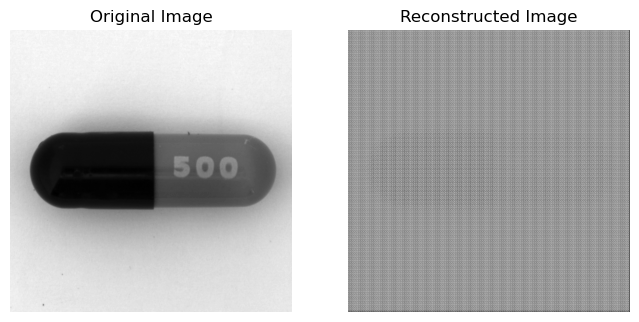

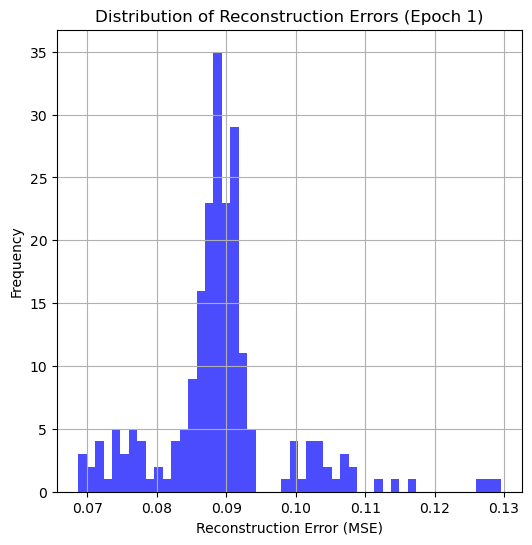

Model saved with test loss: 0.0981
Epoch [2/10], Loss: 0.046687
Model saved with test loss: 0.0467
Epoch [3/10], Loss: 0.031558
Model saved with test loss: 0.0316
Epoch [4/10], Loss: 0.024620
Model saved with test loss: 0.0246
Epoch [5/10], Loss: 0.020251
Model saved with test loss: 0.0203
Epoch [6/10], Loss: 0.017116


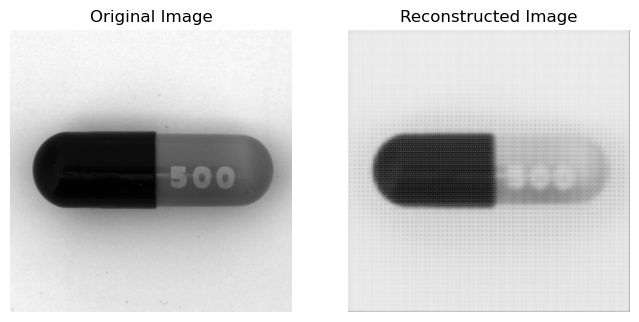

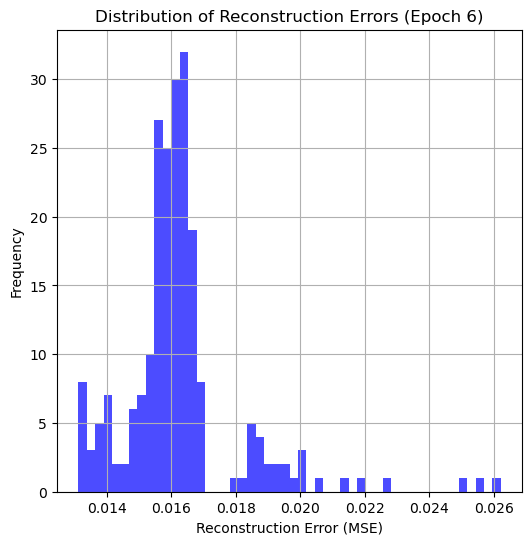

Model saved with test loss: 0.0171
Epoch [7/10], Loss: 0.014908
Model saved with test loss: 0.0149
Epoch [8/10], Loss: 0.013129
Model saved with test loss: 0.0131
Epoch [9/10], Loss: 0.011613
Model saved with test loss: 0.0116
Epoch [10/10], Loss: 0.010338


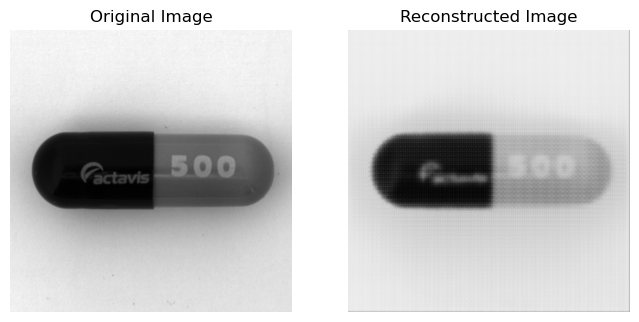

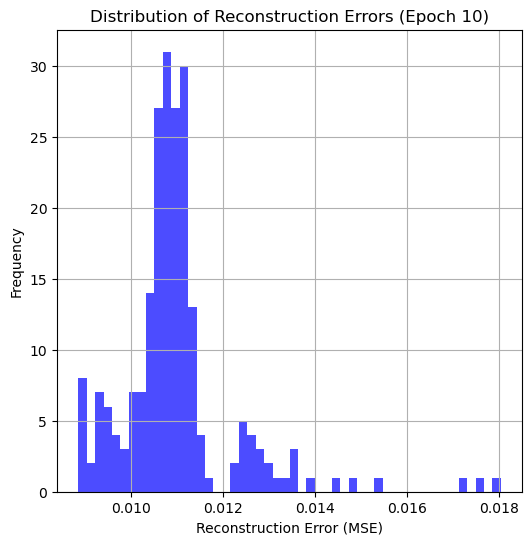

Model saved with test loss: 0.0103
Test Accuracy: 0.1742
False Positive Rate: 0.0000


In [27]:
# Will use the images in the "train/good" directory to establish a baseline of features for defect-free images.
categories = ["capsule", "screw", "cable", "transistor"]
threshold = 0.05  # Threshold for anomaly detection

# Iterate through the directories of images
for item in categories:
    item_path = os.path.join(base_dir, item)
    train_path = os.path.join(item_path, 'train')
    test_path = os.path.join(item_path, 'test')
    ground_truth_path = os.path.join(item_path, 'ground_truth')

    print(f"Processing: {item}")
    # Create the dataset and DataLoader    
    train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = Autoencoder()
    # Initialize loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_autoencoder = train_autoencoder(model, train_loader, item, epochs, device)

    test_dataset = TestDataset(root_dir=test_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    test_autoencoder(trained_autoencoder, test_loader, device, threshold)
    
    break